# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
sns.set_style("darkgrid")

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
display(df_reviews.head())
print()
df_reviews.info()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1)

In [6]:
# Convertir 'end_year', 'runtime_minutes' y 'votes' a valores numéricos, reemplazar \N con NaN
df_reviews['end_year'] = df_reviews['end_year'].replace('\\N', np.nan).astype(float)
df_reviews['runtime_minutes'] = pd.to_numeric(df_reviews['runtime_minutes'], errors='coerce')
df_reviews['votes'] = pd.to_numeric(df_reviews['votes'], errors='coerce')

# Rellenar valores faltantes en 'average_rating' y 'votes' con la media
df_reviews['average_rating'].fillna(df_reviews['average_rating'].mean(), inplace=True)

# Luego, calcular la media y llenar los NaN
mean_votes = df_reviews['votes'].mean()
mean_votes_rounded = round(mean_votes)
df_reviews['votes'].fillna(mean_votes_rounded, inplace=True)
df_reviews['votes'] = df_reviews['votes'].astype('Int64')

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         2279 non-null   float64
 6   runtime_minutes  46843 non-null  float64
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

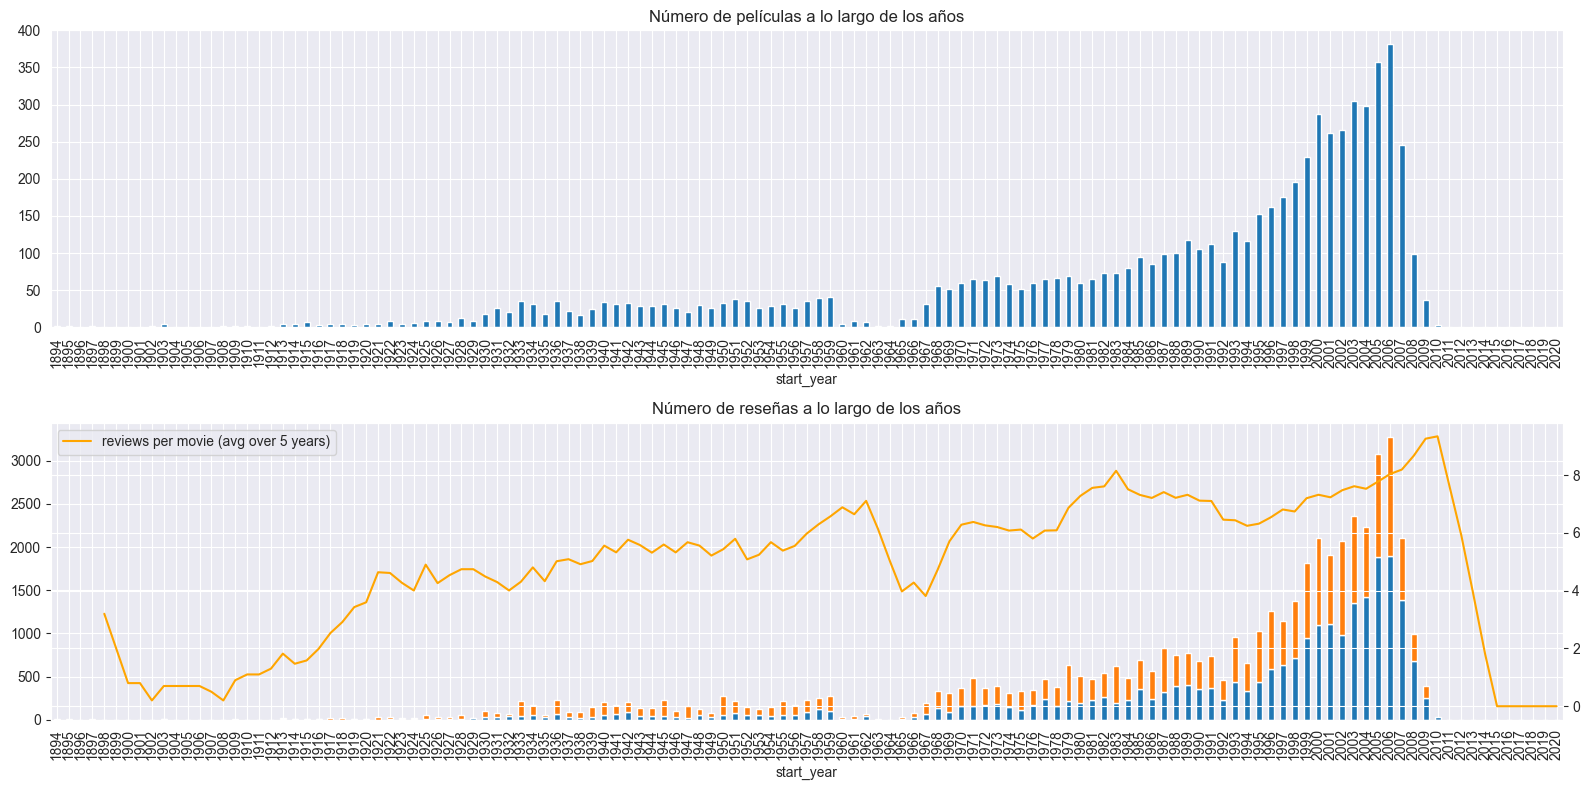

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

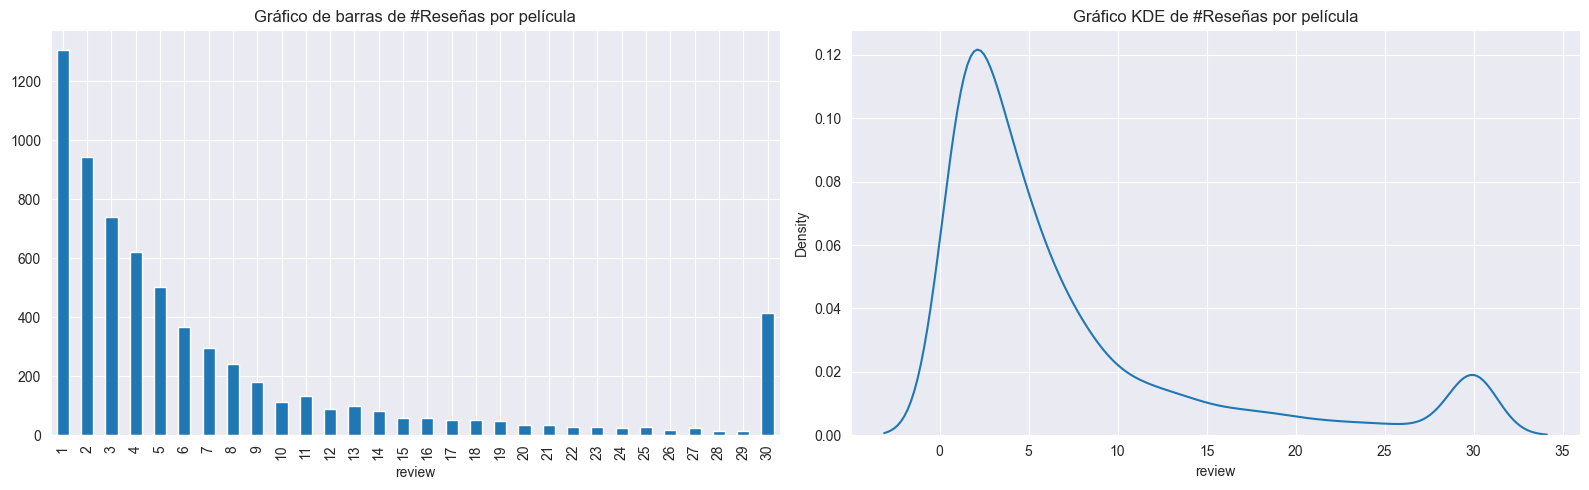

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

pos
0    23715
1    23616
Name: count, dtype: int64


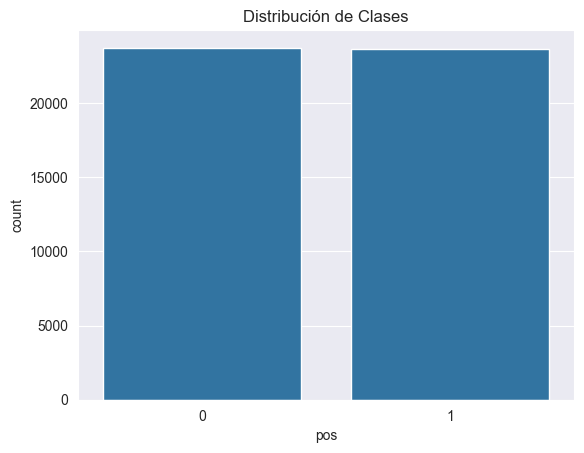

In [9]:

# Supongamos que df_reviews es el DataFrame con tus datos
class_counts = df_reviews['pos'].value_counts()
print(class_counts)

# Visualizar el desequilibrio
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='pos', data=df_reviews)
plt.title('Distribución de Clases')
plt.show()

El desequilibrio de clases se refiere a una situación en la que las clases en un conjunto de datos no están representadas de manera equitativa. En la evaluación del desequilibrio de clases mostró:

Clase 0 (negativa): 23,715 instancias
Clase 1 (positiva): 23,616 instancias

Esto significa que las clases están bastante equilibradas, con una diferencia mínima de 99 instancias entre las dos clases. Dado que la diferencia es tan pequeña, no deberías preocuparte por el desequilibrio de clases en este caso. 

In [10]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

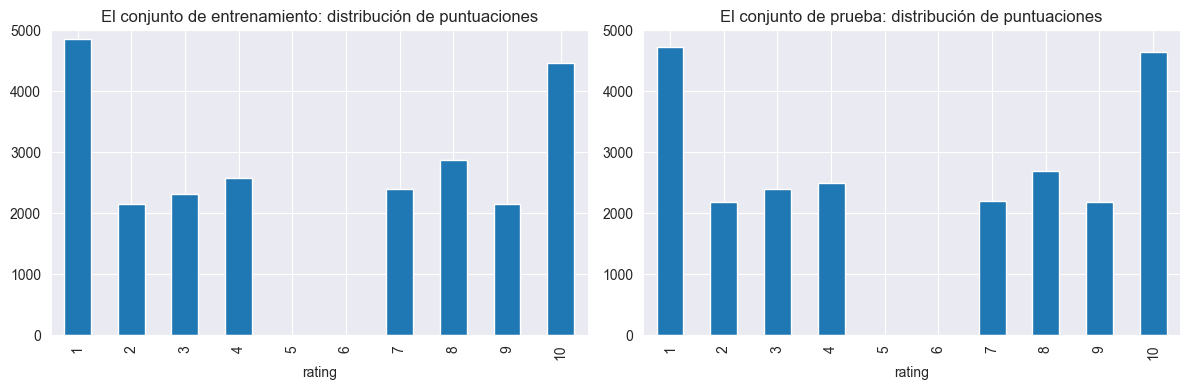

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\chris\AppData\Local\Temp\ipykernel_31092\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\chris\AppData\Local\Temp\ipykernel_31092\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\chris\AppData\Local\Temp\ipykernel_31092\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\chris\AppData\Local\Temp\ipykernel_31092\1324160450.py:31: UserWarning: 

Support for a

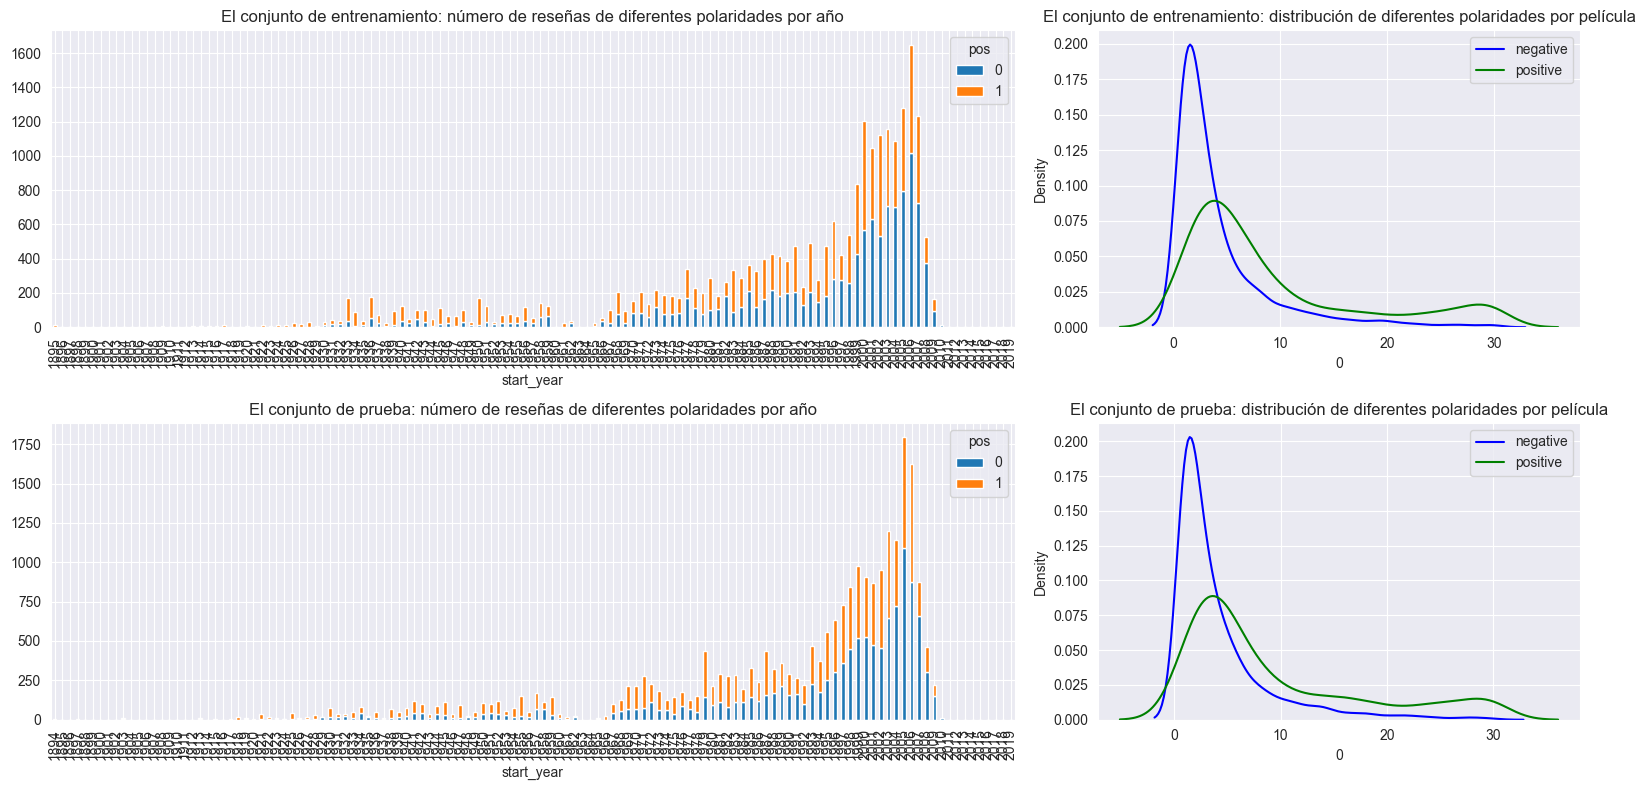

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
# Normalización del texto
def normalize_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar dígitos y signos de puntuación
    text = re.sub(r'[\d\W]+', ' ', text)
    # Eliminar espacios extra
    text = text.strip()
    return text

# Aplicar normalización
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

# Mostrar resultados
print(df_reviews[['review', 'review_norm']])

                                                  review  \
0      The pakage implies that Warren Beatty and Gold...   
1      How the hell did they get this made?! Presenti...   
2      There is no real story the film seems more lik...   
3      Um .... a serious film about troubled teens in...   
4      I'm totally agree with GarryJohal from Singapo...   
...                                                  ...   
47326  This is another of my favorite Columbos. It sp...   
47327  Talk about being boring! I got this expecting ...   
47328  I never thought I'd say this about a biopic, b...   
47329  Spirit and Chaos is an artistic biopic of Miya...   
47330  I'll make this brief. This was a joy to watch....   

                                             review_norm  
0      the pakage implies that warren beatty and gold...  
1      how the hell did they get this made presenting...  
2      there is no real story the film seems more lik...  
3      um a serious film about troubled tee

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

# Modelo 
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(df_reviews_train['review_norm'], train_target)
dummy_predictions = dummy_clf.predict(df_reviews_test['review_norm'])

# Evaluación 
dummy_f1 = f1_score(test_target, dummy_predictions)
print(f'Dummy Classifier F1 score: {dummy_f1}')

Dummy Classifier F1 score: 0.0


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [17]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
# Vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(df_reviews_train['review_norm'])
X_test_tfidf = vectorizer.transform(df_reviews_test['review_norm'])

# Modelo de Regresión Logística
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, train_target)
lr_predictions = lr_model.predict(X_test_tfidf)

# Evaluación
lr_f1 = f1_score(test_target, lr_predictions)
print(f"Logistic Regression F1 Score: {lr_f1}")

Logistic Regression F1 Score: 0.8785102484339711


### Modelo 3 - spaCy, TF-IDF y LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [22]:
# Aplicar preprocesamiento
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# Vectorizador TF-IDF
vectorizer_spacy = TfidfVectorizer()
X_train_tfidf_spacy = vectorizer_spacy.fit_transform(df_reviews_train['review_spacy'])
X_test_tfidf_spacy = vectorizer_spacy.transform(df_reviews_test['review_spacy'])

# Modelo de Regresión Logística
lr_model_spacy = LogisticRegression()
lr_model_spacy.fit(X_train_tfidf_spacy, train_target)
lr_predictions_spacy = lr_model_spacy.predict(X_test_tfidf_spacy)

# Evaluación
lr_f1_spacy = f1_score(test_target, lr_predictions_spacy)
print(f"Logistic Regression (spaCy) F1 Score: {lr_f1_spacy}")

Logistic Regression (spaCy) F1 Score: 0.8825586353944563


### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [23]:
from lightgbm import LGBMClassifier

In [24]:
# Modelo LGBMClassifier
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train_tfidf_spacy, train_target)
lgbm_predictions = lgbm_model.predict(X_test_tfidf_spacy)

# Evaluación
lgbm_f1 = f1_score(test_target, lgbm_predictions)
print(f"LGBMClassifier F1 Score: {lgbm_f1}")

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484050
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
LGBMClassifier F1 Score: 0.858866205500253


###  Modelo 9 - BERT

In [25]:
import torch
import transformers

# Seleccionar una muestra de 200 elementos del conjunto de entrenamiento y prueba
train_sample = df_reviews_train.sample(n=200, random_state=42)
test_sample = df_reviews_test.sample(n=200, random_state=42)

# Objetivos de entrenamiento y prueba para la muestra
train_target_sample = train_sample['pos']
test_target_sample = test_sample['pos']

In [26]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [27]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device='cpu', disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Tokenización y creación de IDs y máscaras de atención
    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Añadir [CLS] y [SEP]
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        ids_list.append(encoding['input_ids'].flatten().tolist())
        attention_mask_list.append(encoding['attention_mask'].flatten().tolist())

    # Establecer el dispositivo de computación (forzando CPU)
    device = torch.device(force_device)
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using device {device}.')

    embeddings = []

    # Obtener embeddings en lotes
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    return np.concatenate(embeddings)

# Obtener embeddings para la muestra del conjunto de entrenamiento usando CPU
train_features_sample = BERT_text_to_embeddings(train_sample['review_norm'], force_device='cpu')
# Obtener embeddings para la muestra del conjunto de prueba usando CPU
test_features_sample = BERT_text_to_embeddings(test_sample['review_norm'], force_device='cpu')

Using device cpu.


  0%|          | 0/2 [00:00<?, ?it/s]

Using device cpu.


  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
print(df_reviews_train['review_norm'].shape)
print(train_target.shape)

(23796,)
(23796,)


In [29]:

# Modelo de Regresión Logística
lr_model_bert = LogisticRegression()
lr_model_bert.fit(train_features_sample, train_target_sample)
lr_predictions_bert = lr_model_bert.predict(test_features_sample)

# Evaluación
lr_f1_bert = f1_score(test_target_sample, lr_predictions_bert)
print(f"Logistic Regression with BERT F1 Score: {lr_f1_bert}")

Logistic Regression with BERT F1 Score: 0.7872340425531915


In [30]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [31]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos
# Definir la función de preprocesamiento del texto
def text_preprocessing(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar dígitos y signos de puntuación
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Eliminar espacios adicionales
    text = text.strip()
    return text

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 2

In [32]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_model.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.18:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.28:  i didnt expect the reboot to be so good writers really cared about the source material
0.43:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_model_spacy.predict_proba(vectorizer_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.23:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didnt expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [34]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer_spacy
my_reviews_pred_prob = lgbm_model.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  i did not simply like it not my kind of movie
0.56:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.54:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.60:  i didnt expect the reboot to be so good writers really cared about the source material
0.76:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.28:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.72:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 9

In [35]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = lr_model_bert.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.43:  i did not simply like it not my kind of movie
0.10:  well i was bored and felt asleep in the middle of the movie
0.92:  i was really fascinated with the movie
0.05:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.03:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.71:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusiones

De los modelos evaluados pordemos concluir que Logistic Regression (spaCy) demostró ser muy efectivo para el análisis de sentimiento en reseña de películas. Con un valor F1 de 0.88, este modelo supero el valor del umbral de 0.85, lo que demuestra su capacidad para manejar el desequilibrio de clases y proporcionar predicciones precisas y fiables.


# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 